In [12]:
!pip install torchvision
!pip install pyro-ppl
!pip install matplotlib


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 28.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.8/960.8 kB 24.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.2/63.2 kB 2.3 MB/s eta 0:00:00

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


# Bayesian Neural Network

In [13]:
from pyro.nn import PyroModule
from pyro.nn import PyroSample
import pyro
import pyro.distributions as dist
import torch
import torch.nn.functional as F
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from torch.nn import ReLU
from torch.nn import Identity
from torch.nn import Sequential
from torch.nn import Softmax, LogSoftmax
from torch import randn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from pyro.infer.autoguide import AutoNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from torchvision import transforms

Fontconfig warning: ignoring UTF-8: not a valid region tag


In [5]:
class BayesianMLP(PyroModule):
  def __init__(self, input_size:int = 784, output_size:int = 10):

    super().__init__()
    self.fc1 = PyroModule[nn.Linear](1024, input_size)
    self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([1024, input_size]).to_event(2))
    self.fc1.bias = PyroSample(dist.Normal(0., 1.).expand([1024]).to_event(1))
    self.fc2 = PyroModule[nn.Linear](output_size, 1024)
    self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([output_size, 1024]).to_event(2))
    self.fc2.bias = PyroSample(dist.Normal(0., 1.).expand([output_size]).to_event(1))
    self.relu = nn.ReLU()
    self.softmax = LogSoftmax(dim=1)
  
  def forward(self, input, output=None):
    out = self.fc1(input)
    out = self.relu(out)
    out = self.fc2(out)

    logits = self.softmax(out)

    with pyro.plate("data", out.shape[0]):
        return pyro.sample("obs", dist.Categorical(logits=logits), obs=output)

In [9]:
train_dataset = MNIST(
    root = os.getcwd(), 
    train = True, 
    download = True, 
    transform = transforms.Compose(
        [
          transforms.ToTensor(), 
          transforms.Normalize((0.1307,), (0.3081,))
        ]
    )
)

train_loader = DataLoader(train_dataset, 128, shuffle = True)

test_dataset = MNIST(
    root = os.getcwd(), 
    train = False, 
    download = True, 
    transform = transforms.Compose(
        [
          transforms.ToTensor(), 
          transforms.Normalize((0.1307,), (0.3081,))
        ]
    )
)

100%|██████████| 9912422/9912422 [00:00<00:00, 35336518.80it/s]


Extracting /Users/stevenhyun/Desktop/bayesian-neural-net/MNIST/raw/train-images-idx3-ubyte.gz to /Users/stevenhyun/Desktop/bayesian-neural-net/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 5797075.70it/s]

Extracting /Users/stevenhyun/Desktop/bayesian-neural-net/MNIST/raw/train-labels-idx1-ubyte.gz to /Users/stevenhyun/Desktop/bayesian-neural-net/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 21176390.21it/s]


Extracting /Users/stevenhyun/Desktop/bayesian-neural-net/MNIST/raw/t10k-images-idx3-ubyte.gz to /Users/stevenhyun/Desktop/bayesian-neural-net/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3636985.26it/s]

Extracting /Users/stevenhyun/Desktop/bayesian-neural-net/MNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/stevenhyun/Desktop/bayesian-neural-net/MNIST/raw



In [10]:
model = BayesianMLP()
guide = AutoNormal(model)
adam = pyro.optim.Adam({"lr": 0.001})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

EPOCH = 10

pyro.clear_param_store()

for e in range(EPOCH):
  loss = 0
  for data in train_loader:
    x = torch.flatten(data[0], start_dim = 1)
    y = data[1]
    loss += svi.step(x, y)
   
  epoch_loss = loss / len(train_loader.dataset)
  print(f"At epoch: {e} the loss was: {loss}")

At epoch: 0 the loss was: 609480181.6037489
At epoch: 1 the loss was: 452915638.7762163
At epoch: 2 the loss was: 312217785.6318756
At epoch: 3 the loss was: 195731474.15185356
At epoch: 4 the loss was: 110490231.5963028
At epoch: 5 the loss was: 57503042.32086569
At epoch: 6 the loss was: 29713795.343616724
At epoch: 7 the loss was: 16868630.895879745
At epoch: 8 the loss was: 11165287.688986778
At epoch: 9 the loss was: 8561906.910837173


[6.984]
[2.708]
[1.218]
[0.098]
[4.778]


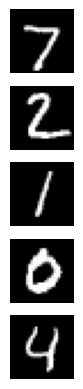

In [14]:
NUM_TO_DISPLAY = 5

f, axes = plt.subplots(NUM_TO_DISPLAY, 1)

pred = Predictive(model, guide=guide, num_samples=500)

for i, test_data in enumerate(test_dataset):
  if i >= NUM_TO_DISPLAY:
    break
  axes[i].set_axis_off()
  axes[i].imshow(test_data[0].squeeze(0), cmap = 'gray')
  prediction = pred(test_data[0].flatten(0).unsqueeze(0))
  print(prediction['obs'].T.numpy().mean(axis = 1))